# Import Dependencies and Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Layer, RandomCrop, RandomFlip, RandomRotation, RandomTranslation,
                                    Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob
import os
from dataclasses import dataclass
import random

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("Running on TPU:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not found. Using Multi GPU System")
    strategy = tf.distribute.MirroredStrategy()

TPU not found. Using Multi GPU System


# 1. Data Processing Pipeline

## 1.1 Constants and Hyper Params

In [3]:
@dataclass
class Params:
    train_folder : str = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/"
    train_class_file : str = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/ImageSets/CLS-LOC/train_cls.txt"
    val_size : float = 0.2
    BATCH : int = 128
    learning_rate : float = 0.01
    momentum : float = 0.9
    weight_decay : float =0.0005
    EPOCH : int = 150

## 1.2 Reading and Processing Data, Labels

In [4]:
# # Read Image Paths with Folder IDs
# with open(Params.train_class_file, 'r') as f:
#     lines = f.read()

# # Get absolute image paths and get labels
# images_pop = [os.path.join(Params.train_folder, l.split(" ")[0]+'.JPEG') for l in lines.split('\n') if l]

# sample_size = 80000
# images = random.choices(images_pop, k = sample_size)
# labels = [img_path.split('/')[-2] for img_path in images]
# assert len(images)==len(labels)

# Small Dataset By Intel
images = glob("/kaggle/input/intel-image-classification/seg_train/seg_train/*/*.*")
labels = [img_path.split('/')[-2] for img_path in images]
assert len(images)==len(labels)

# Create class to index mapping for one-hot-encoding
unique_labels = list(set(labels))
class2idx = {c:i for i,c in enumerate(unique_labels)}
idx2class = {i:c for c,i in class2idx.items()}

# Creating the one-hot-encodings
label_idx = [class2idx[l] for l in labels]
label_one_hot = tf.one_hot(label_idx, depth=len(idx2class)).numpy()

## 1.3 Train-Val Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(images, label_one_hot, stratify=labels, 
                                                  test_size=Params.val_size, random_state = 42)

In [6]:
# free up memory
del label_one_hot
del labels
# del f
# del lines

## 1.4 Pre-processing Functions/ utils

In [7]:
def resize(image):
    """Apply before batching the dataset"""
    return tf.image.resize([image], size=[256,256])[0]

def read_jpeg(path : str):
    """Apply before batching"""
    img = tf.io.decode_jpeg(tf.io.read_file(path))
    if tf.shape(img)[-1]==1:
        # handling gray scale images by repeating the single channel 3 times
        img = tf.repeat(img, repeats=3, axis=-1)
    elif tf.shape(img)[-1]>3:
        img = img[...,:3]
    return img
    
def scale_pixels(img):
    """Apply before batching"""
    return img/255

def random_crop(image):
    """Apply before batching"""
    return tf.image.random_crop(image, size=(224, 224, 3))

def preprocessing(path):
    img = read_jpeg(path)
    resized = resize(img)
    scaled = scale_pixels(resized)

    # augmentation
    # cropped = random_crop(scaled)
    # left_right_flipped = tf.image.random_flip_left_right(cropped)
    # up_down_clipped = tf.image.random_flip_up_down(left_right_flipped)
    return scaled

## 1.5 Define tf-Datasets

In [8]:
# Training Dataset
tr_dataset = tf.data.Dataset.from_tensor_slices(X_train)
tr_lables_ds = tf.data.Dataset.from_tensor_slices(y_train)
tr_dataset = tr_dataset.map(preprocessing) # Preprocess the images

train_ds = tf.data.Dataset.zip(tr_dataset, tr_lables_ds) # Zip with labels
train_ds = train_ds.batch(Params.BATCH).cache() # Add batch dimension


# Validation Dataset
val_dataset = tf.data.Dataset.from_tensor_slices(X_val)
val_lables_ds = tf.data.Dataset.from_tensor_slices(y_val)
val_dataset = val_dataset.map(preprocessing) # Preprocess the images

val_ds = tf.data.Dataset.zip(val_dataset, val_lables_ds) # Zip with labels
val_ds = val_ds.batch(Params.BATCH).cache() # Add batch dimension
train_ds, val_ds

(<CacheDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>)

(128, 256, 256, 3) (128, 6)
(128, 256, 256, 3) (128, 6)


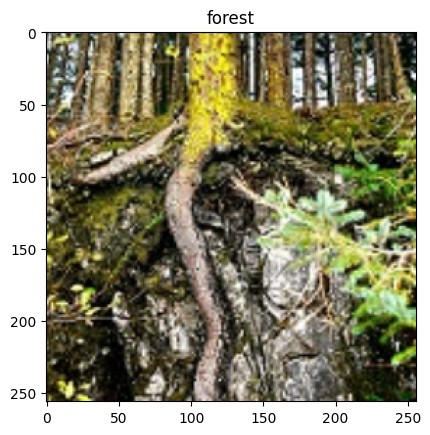

In [9]:
it = train_ds.as_numpy_iterator()
for x,y in it:
    break
print(x.shape, y.shape)
it = train_ds.as_numpy_iterator()
for x,y in it:
    break
print(x.shape, y.shape)
i = 10
plt.imshow(x[i])
plt.title(idx2class[np.argmax(y[i])])
plt.show()
del x
del y
del it

# 2. Model Definition

## 2.1 Data Augmentation Pipeline - 
Not Exactly same of the paper

In [10]:
with strategy.scope():
    augmentation_model = tf.keras.models.Sequential([
        Input(shape=(None, None, 3)),
        RandomCrop(height=224, width=224),
        RandomFlip(),
        RandomRotation(factor=0.5),
        RandomTranslation(height_factor=0.3, width_factor=0.3)
    ])
    augmentation_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_crop (RandomCrop)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 AlexNet - Base

In [11]:
class LocalResponseNorm(Layer):
    def __init__(self, n : int, k : float, alpha : float, beta : float):
        super(LocalResponseNorm, self).__init__()
        self.n = n
        self.k = k
        self.alpha = alpha
        self.beta = beta
    def call(self, inputs):
        return tf.nn.local_response_normalization(inputs, depth_radius = self.n,
                                                            bias = self.k,
                                                            alpha = self.alpha,
                                                            beta = self.beta,)
class Padding(Layer):
    def __init__(self, paddings):
        super(Padding, self).__init__()
        self.paddings = paddings
    def call(self, inputs):
        """Expecting any dimension matching with the padding elements provided"""
        return tf.pad(inputs, paddings = self.paddings)

In [12]:
with strategy.scope():
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01) # as per section 5
    zero_bias_initializer = tf.constant_initializer(value=0.0)
    one_bias_initializer = tf.constant_initializer(value=1.0)
    alexnet = tf.keras.models.Sequential([
        Input(shape=(224,224,3)),
        # first conv layer with pooling and normalization
        Padding(paddings = ((0,0), (2,2), (2,2), (0,0))),
        # output = (w+2*p-f)/s +1 = (224 + 2*2 - 11)/(4) + 1 = 55
        Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', kernel_initializer = initializer, bias_initializer=zero_bias_initializer), # (B, 55, 55, 96)
        LocalResponseNorm(n=5, k=2, alpha = 1e-4, beta=0.75), # as per section 3.3
        MaxPool2D(pool_size=3, strides=2), # Overlapping Pooling as per paper (B, 27, 27, 96)
        
        # second conv layer with pooling and normalization
        Padding(paddings = ((0,0), (2,2), (2,2), (0,0))),
        # output = (w+2*p-f)/s +1= (27+2*2-5)/1 + 1 = 27 
        Conv2D(filters=256, kernel_size=5, activation='relu', kernel_initializer = initializer, bias_initializer = one_bias_initializer), # (B, 27, 27, 256)
        LocalResponseNorm(n=5, k=2, alpha = 1e-4, beta=0.75), # as per section 3.3
        MaxPool2D(pool_size=3, strides=2), # Output = (B, 13, 13, 256)
        
        # third, fourth, fifth layer WITHOUT pooling or normalization
        # output = (w+2*p-f)/s + 1 = (13+2*1-3)/1 + 1 = 13
        # Padding to keep the shape intact. we can also use padding='same' in Conv2D Layer's also.
        Padding(paddings = ((0,0), (1,1), (1,1), (0,0))), 
        Conv2D(filters=384, kernel_size=3, activation='relu', kernel_initializer = initializer, bias_initializer=zero_bias_initializer),
        Padding(paddings = ((0,0), (1,1), (1,1), (0,0))),
        Conv2D(filters=384, kernel_size=3, activation='relu', kernel_initializer = initializer, bias_initializer = one_bias_initializer),
        Padding(paddings = ((0,0), (1,1), (1,1), (0,0))), 
        Conv2D(filters=256, kernel_size=3, activation='relu', kernel_initializer = initializer, bias_initializer = one_bias_initializer),
    
        Flatten(),
        
        Dropout(rate=0.5), # As per section 4.2
        Dense(4096, activation='relu', kernel_initializer = initializer, bias_initializer = one_bias_initializer),
        
        Dropout(rate=0.5), # As per section 4.2
        Dense(4096, activation='relu', kernel_initializer = initializer, bias_initializer = one_bias_initializer),
    
        Dense(len(idx2class), activation='linear', kernel_initializer = initializer)
    ])
    
    alexnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding (Padding)                    │ (None, 228, 228, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ local_response_norm                  │ (None, 55, 55, 96)          │               0 │
│ (LocalResponseNorm)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ padding_1 (Padding)                  │ (None, 31, 31, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ local_response_norm_1                │ (None, 27, 27, 256)         │               0 │
│ (LocalResponseNorm)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ padding_2 (Padding)                  │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ padding_3 (Padding)                  │ (None, 15, 15, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ padding_4 (Padding)                  │ (None, 15, 15, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     177,213,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │          24,582 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 197,766,534 (754.42 MB)

 Trainable params: 197,766,534 (754.42 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Combined Model under CUDA env
**Optimizer, Loss and Metric Setup**

In [13]:
with strategy.scope():
    # optimizer = SGD(learning_rate = Params.learning_rate, momentum = Params.momentum, weight_decay=Params.weight_decay)
    optimizer = Adam()
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy']
    combined_model = tf.keras.models.Sequential([
        augmentation_model,
        alexnet
    ])
    
    combined_model.summary(expand_nested=True)
    combined_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_crop (RandomCrop)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 224, 224, 3)         │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation              │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 6)                   │     197,766,534 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ padding (Padding)               │ (None, 228, 228, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d (Conv2D)                 │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ local_response_norm             │ (None, 55, 55, 96)          │               0 │
│ (LocalResponseNorm)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ padding_1 (Padding)             │ (None, 31, 31, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ local_response_norm_1           │ (None, 27, 27, 256)         │               0 │
│ (LocalResponseNorm)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ padding_2 (Padding)             │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ padding_3 (Padding)             │ (None, 15, 15, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ padding_4 (Padding)             │ (None, 15, 15, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 197,766,534 (754.42 MB)

 Trainable params: 197,766,534 (754.42 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Learning Rate Callback and Training 

In [14]:
lr_on_platue = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=0.0001)
ckpt = ModelCheckpoint(filepath = "model.keras", save_best_only=True, verbose=1)

In [15]:
combined_model.fit(train_ds, batch_size=Params.BATCH, epochs = Params.EPOCH, callbacks=[lr_on_platue, ckpt],
                  validation_data = val_ds, verbose=2)

Epoch 1/150

Epoch 1: val_loss improved from inf to 1.89993, saving model to model.keras
88/88 - 57s - 649ms/step - accuracy: 0.1693 - loss: 13.3902 - val_accuracy: 0.1696 - val_loss: 1.8999 - learning_rate: 0.0010
Epoch 2/150

Epoch 2: val_loss improved from 1.89993 to 1.84124, saving model to model.keras
88/88 - 40s - 451ms/step - accuracy: 0.1644 - loss: 1.8497 - val_accuracy: 0.1696 - val_loss: 1.8412 - learning_rate: 0.0010
Epoch 3/150

Epoch 3: val_loss improved from 1.84124 to 1.81221, saving model to model.keras
88/88 - 40s - 451ms/step - accuracy: 0.1683 - loss: 1.8392 - val_accuracy: 0.1803 - val_loss: 1.8122 - learning_rate: 0.0010
Epoch 4/150

Epoch 4: val_loss improved from 1.81221 to 1.57346, saving model to model.keras
88/88 - 40s - 449ms/step - accuracy: 0.2705 - loss: 1.7051 - val_accuracy: 0.3459 - val_loss: 1.5735 - learning_rate: 0.0010
Epoch 5/150

Epoch 5: val_loss improved from 1.57346 to 1.56491, saving model to model.keras
88/88 - 40s - 453ms/step - accuracy: 0

# 4. Plotting Loss and Metrics

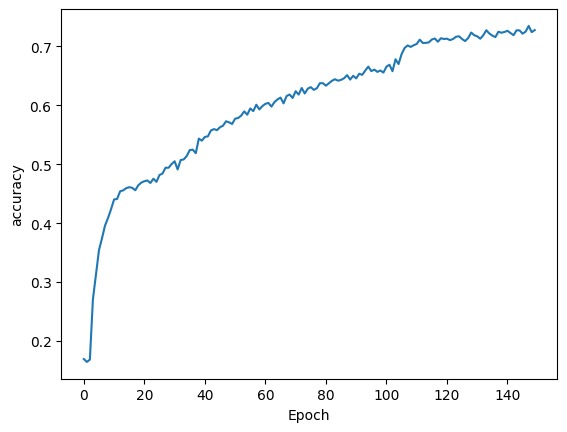

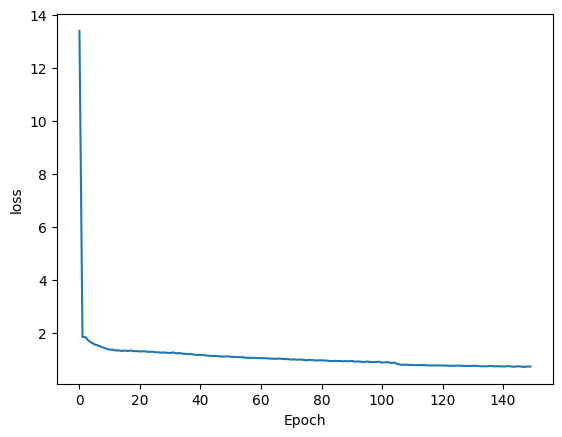

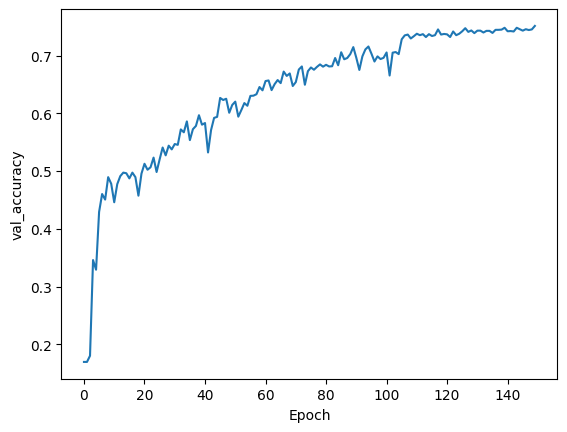

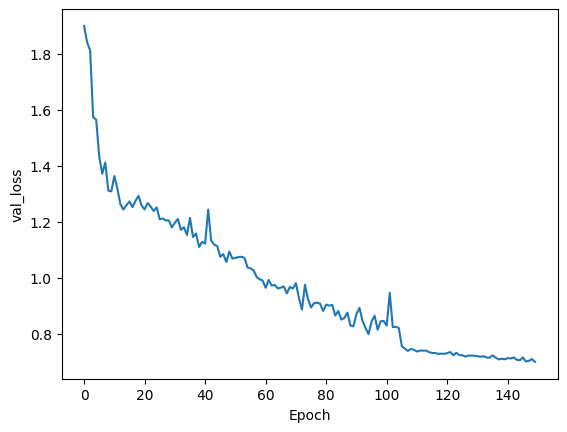

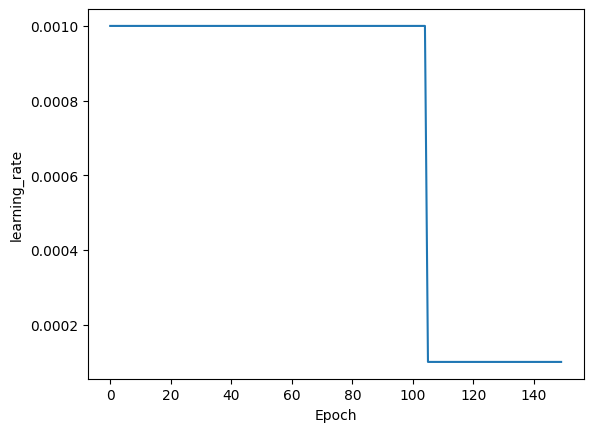

In [16]:
for k, v in combined_model.history.history.items():
    plt.plot(v)
    plt.xlabel('Epoch')
    plt.ylabel(k)
    plt.show()